In [1]:
%matplotlib inline

import os.path
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader
from datasets import FashionMnistDataset
from models import ConvolutionalNetwork
import matplotlib.pyplot as plt
from tqdm import tqdm
from statistics import mean
import pickle

import plotly
import plotly.graph_objs as go

plotly.offline.init_notebook_mode(connected=True)

In [2]:
train_dataset = FashionMnistDataset(train=True)
test_dataset = FashionMnistDataset(train=False)

train_loader = DataLoader(train_dataset, batch_size=160, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10000, shuffle=True)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

Processing...
Done!


# Exploring

In [3]:
# Get a random image of a the desired class
def get_random_image_of_class(x, y, desired_class):
    random = torch.randint(0, len(y) - 1, (1, 0), dtype=torch.long).item()
    while y[random] != desired_class:
        random = torch.randint(0, len(y) - 1, (1, 0), dtype=torch.long).item()    
    
    return x[random].squeeze(0)

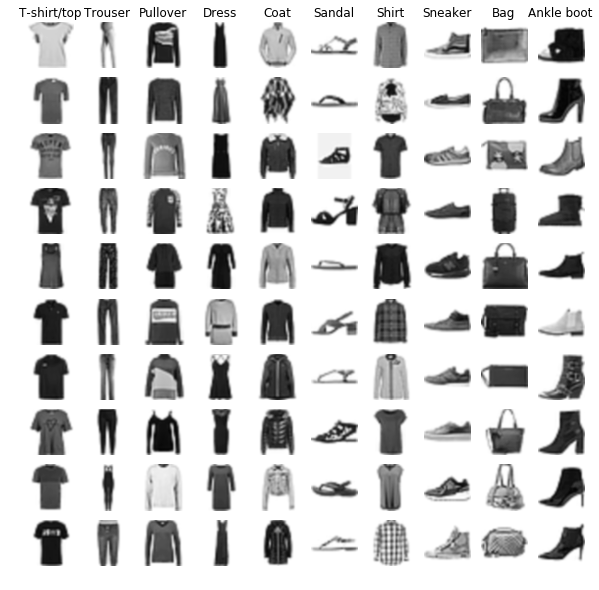

In [4]:
fig, axes = plt.subplots(10, 10, figsize=(10, 10))

for row in range(10):
    for column in range(10):
        axes[0, column].set_title(classes[column])
        axes[row, column].imshow(get_random_image_of_class(train_dataset.data, train_dataset.labels, column), cmap='binary', interpolation='bicubic')
        axes[row, column].axis('off')

plt.show()

# Defining loss function and backpropagation

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ConvolutionalNetwork().to(device)
params = list(net.parameters())
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
print(net)

ConvolutionalNetwork(
  (conv1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=84, out_features=10, bias=True)
    (1): ReLU()
  )
)


# Training

In [6]:
epochs = 100
loss_history_file = './logs/fashion-mnist-convolutional-network.loss-history.pkl'
model_file = './models/fashion-mnist-convolutional-network.pt'

if os.path.isfile(loss_history_file) and os.path.getsize(loss_history_file) > 0:
    with open(loss_history_file, 'rb') as f:
        loss_history = pickle.load(f)
else:
    loss_history = []

if os.path.isfile(model_file) and os.path.getsize(model_file) > 0:
    state = torch.load(model_file)
    net.load_state_dict(state)

for epoch in tqdm(range(epochs), desc='Training'):
    losses_in_epoch = []
    for data in train_loader:
        inputs, labels = [d.to(device) for d in data]
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        losses_in_epoch.append(loss.item())
    loss_history.append(mean(losses_in_epoch))

    if epoch % 5 == 0:
        torch.save(net.state_dict(), model_file)
        with open(loss_history_file, 'wb') as f:
            pickle.dump(loss_history, f)

torch.save(net.state_dict(), model_file)
with open(loss_history_file, 'wb') as f:
    pickle.dump(loss_history, f)


Training: 100%|██████████| 100/100 [03:30<00:00,  2.10s/it]


In [7]:
plotly.offline.iplot({
    'data': [
        go.Scatter(
            y=loss_history
        )
    ],
    'layout': go.Layout(title='Loss History')
})

# Testing

In [8]:
correct = 0
total   = 0

class_correct = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
class_total   = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
with torch.no_grad():
    for data in test_loader:
        images, labels = [d.to(device) for d in data]
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        for i, prediction in enumerate(predicted):
            total += 1
            class_total[labels[i]] += 1
            correct += 1 if prediction.item() == labels[i] else 0
            class_correct[labels[i]] += 1 if prediction.item() == labels[i] else 0
            
print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))
for i, o in enumerate(class_correct):
    print(classes[i] + ':', '%.2f %%' % (100 * o / class_total[i]))

Accuracy of the network on the 10000 test images: 88.73 %
T-shirt/top: 85.00 %
Trouser: 97.60 %
Pullover: 83.00 %
Dress: 89.50 %
Coat: 81.60 %
Sandal: 95.90 %
Shirt: 67.20 %
Sneaker: 96.00 %
Bag: 95.70 %
Ankle boot: 95.80 %
